Задача:\
    На вход подается множество картинок и на их основе необходимо сгенерировать план квартиры. Также нужно сформировать json файл, в котором пометить координаты всех углов квартиры как вершины графа и стены как ребра.

Этапы:\
    1. Определить и обучить модель, которая способна по переданной картинке генерировать маску пола.\
    2. Объединить все картинки в одну панораму и соответственно объединить их маски.\
    3. Из панорамы масок пола нужно выделить граф, углы, которого соответствуют углам в квартире, а ребра соответствуют стенам.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

IMAGE_SIZE = (128, 128)

Используем модель из smp обученную на датасете imagenet для сегментации. Модель была дообучена задаче сегментации пола на датасете из каталога Dataset_floor_example.

In [2]:
transform = A.Compose([
    A.Resize(height=IMAGE_SIZE[1], width=IMAGE_SIZE[0]),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

model = smp.Unet(
    encoder_name="efficientnet-b3",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None
)
model.load_state_dict(torch.load('model/checkpointsv6/model_2.pth'))

def use_model(path):
    imgs = []
    imgs_prep = []
    masks_res = []
    for p in path:
        im = cv2.imread(p)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        imgs.append(im.copy())
        
        im = transform(image=im)['image']
        imgs_prep.append(im)

    imgs_prep = torch.stack(imgs_prep)
    masks = torch.squeeze(model(imgs_prep), dim=1)
    masks = torch.sigmoid(masks) > 0.5

    for i in range(len(imgs)):
        m = cv2.resize(np.where(masks[i], 255, 0).astype(np.uint8), imgs[i].shape[-2::-1])
        masks_res.append(m.astype(np.uint8))
    
    return imgs, masks_res

Функции ниже позволяют склеить фото в одну панораму и соответственно склеить их маски

In [3]:
H_templ_ratio = 0.2

def genTemplate(img): 
    global H_templ_ratio
    h, w = img.shape[:2]
    x1 = int(float(w) * (1 - H_templ_ratio))
    x2 = w
    return img[:, x1:x2]

def mat2Edges(img):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(img, 100, 200)
    return edged

def addBlackMargins(img, top, bottom, left, right):
    h, w = img.shape[:2]
    if len(img.shape) == 3:
        result = np.zeros((h + top + bottom, w + left + right, 3), dtype=np.uint8)
    else:
        result = np.zeros((h + top + bottom, w + left + right), dtype=np.uint8)
    result[top:top + h, left:left + w] = img
    return result

def calcFinalImgSize(imgs, loc):
    global H_templ_ratio
    y_offset = 0
    max_margin_top = 0
    max_margin_bottom = 0
    current_margin_top = 0
    current_margin_bottom = 0

    h_init, w_init = imgs[0].shape[:2]
    w_final = w_init

    for i in range(len(loc)):
        h, w = imgs[i].shape[:2]
        h2, w2 = imgs[i + 1].shape[:2]

        current_margin_top += loc[i][1]
        current_margin_bottom += (h2 - loc[i][1]) - h

        if current_margin_top > max_margin_top:
            max_margin_top = current_margin_top
        if current_margin_bottom > max_margin_bottom:
            max_margin_bottom = current_margin_bottom

        x_templ = int(float(w) * H_templ_ratio)
        w_final += (w2 - x_templ - loc[i][0])

    h_final = h_init + max_margin_top + max_margin_bottom
    return max_margin_top, h_final, w_final

def matchImages(imgs, templates_loc):
    for i in range(len(imgs) - 1):
        template = genTemplate(imgs[i])
        template = mat2Edges(template)
        h_templ, w_templ = template.shape[:2]

        margin_top = margin_bottom = h_templ
        margin_left = margin_right = 0

        img_padded = addBlackMargins(imgs[i + 1], margin_top, margin_bottom, margin_left, margin_right)
        img_padded = mat2Edges(img_padded)

        res = cv2.matchTemplate(img_padded, template, cv2.TM_CCOEFF)
        _, _, _, templ_pos = cv2.minMaxLoc(res)
        rectified_templ_pos = (templ_pos[0] - margin_left, templ_pos[1] - margin_top)
        templates_loc.append(rectified_templ_pos)
        print(rectified_templ_pos)

def stitchImagesWithMasks(imgs, floor_masks, templates_loc):
    y_offset, h_final, w_final = calcFinalImgSize(imgs, templates_loc)

    is_mask_color = len(floor_masks[0].shape) == 3
    mask_channels = 3 if is_mask_color else 1

    stitched_img = np.zeros((h_final, w_final, 3), dtype=np.uint8)
    if mask_channels == 3:
        stitched_mask = np.zeros((h_final, w_final, 3), dtype=np.uint8)
    else:
        stitched_mask = np.zeros((h_final, w_final), dtype=np.uint8)

    h0, w0 = imgs[0].shape[:2]
    stitched_img[y_offset:y_offset + h0, 0:w0] = imgs[0]
    stitched_mask[y_offset:y_offset + h0, 0:w0] = floor_masks[0]

    origin = (y_offset, 0) 

    for j in range(len(templates_loc)):
        h, w = imgs[j].shape[:2]
        h2, w2 = imgs[j + 1].shape[:2]

        y1 = origin[0] - templates_loc[j][1]
        y2 = y1 + h2
        x_templ = int(float(w) * (1 - H_templ_ratio))
        x1 = origin[1] + x_templ - templates_loc[j][0]
        x2 = x1 + w2

        stitched_img[y1:y2, x1:x2] = imgs[j + 1]
        stitched_mask[y1:y2, x1:x2] = floor_masks[j + 1]
        origin = (y1, x1)

    return stitched_img, stitched_mask

In [4]:
source_dir = 'img/data/'
paths = [f'{source_dir}/{p}.jpg' for p in range(1, 7)]

In [5]:
imgs, masks = use_model(paths)

templates_loc = []
matchImages(imgs, templates_loc)
result = stitchImagesWithMasks(imgs, masks, templates_loc)

(933, -110)
(913, -87)
(942, -124)
(984, -54)
(938, -48)


Левая картинка это панорама комнаты, а правая это получившаяся маска пола.

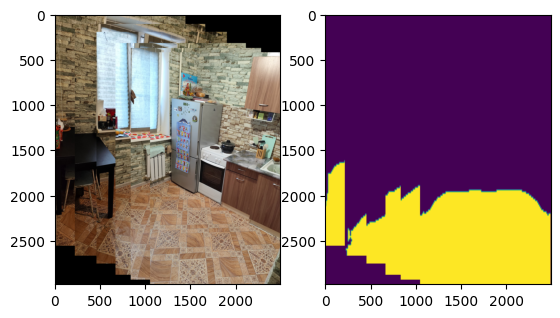

In [6]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(result[0])
ax[1].imshow(result[1])

Архитектура модели была выбрана довольно простая, так как обучение проходило на CPU. При наличии GPU можно выбрать более сложную и подходящую архитектуру, что положительно скажется на качестве результата.